<a href="https://colab.research.google.com/github/fichel/fast.ai-practice/blob/dev/emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Classifier

We're going to use the Fastai library to classify six types of emotions based on images of people:

* sadness
* anger
* happiness
* fear
* disgust
* surprise

## Download the Images

We'll start off downloading images of each emotion. For this, we'll use DuckDuckGo's `duckduckgo_search` package

In [1]:
# install dependencies
! pip install -Uqq fastai duckduckgo_search

     |████████████████████████████████| 62 kB 1.9 MB/s 
     |████████████████████████████████| 96 kB 7.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [2]:
# download images
from duckduckgo_search import ddg_images

ddg_images(keywords='sad person', max_results=2)

[{'title': 'Sad Person - Cliparts.co',
  'image': 'http://cliparts.co/cliparts/di9/rad/di9radxAT.jpg',
  'thumbnail': 'https://tse1.mm.bing.net/th?id=OIP.zfTU9WGLwSbc8hnHw_Gl8wHaDt&pid=Api',
  'url': 'http://cliparts.co/sad-person',
  'height': 1000,
  'width': 2000,
  'source': 'Bing'},
 {'title': 'Why Do So Many People Suffer from Depression? - Achieve TMS',
  'image': 'https://achievetms.com/wp-content/uploads/2019/05/bigstock-Sad-Depressed-Woman-Suffering-278315785.jpg',
  'thumbnail': 'https://tse4.explicit.bing.net/th?id=OIP.eToYTJJmQ0UbJrW1fuh0-wHaE8&pid=Api',
  'url': 'https://achievetms.com/why-do-so-many-people-suffer-from-depression/',
  'height': 1867,
  'width': 2800,
  'source': 'Bing'}]

In [3]:
# automating the search
from fastcore.all import *

def search_images(term, max_results):
    return L(ddg_images(keywords=f'{term} person', max_results=max_results)).itemgot('image')

In [4]:
results = search_images('sad', max_results=2); results

(#2) ['http://cliparts.co/cliparts/di9/rad/di9radxAT.jpg','https://achievetms.com/wp-content/uploads/2019/05/bigstock-Sad-Depressed-Woman-Suffering-278315785.jpg']

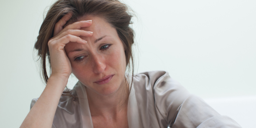

In [5]:
# display the image
from fastai.vision.all import *
from fastdownload import download_url

dest='sad_sample.jpg'
download_url(url=results[0], dest=dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256)

In [11]:
# download images of each emotion
path = Path('emotions')
search = dict(
    sadness='sad',
    anger='angry',
    happiness='happy',
    fear='fearful',
    disgust='disgusted',
    surprise='surprised'
)

for k, v in search.items():
    dest = path/k
    dest.mkdir(parents=True, exist_ok=True)
    print(f'Downloading images of {k}...')
    download_images(dest, urls=search_images(v, max_results=50))
    resize_images(path=dest, max_size=400, dest=dest)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [9]:
# delete path and images
# for p in path.ls():
#     files = L(p.ls())
#     files.map(Path.unlink)
#     p.rmdir()

In [12]:
# check how many images were downloaded per class
for p in path.ls():
    print(f'{p.name}: {len(p.ls())}')

surprise: 42
fear: 49
disgust: 50
sadness: 48
anger: 47
happiness: 46


In [13]:
# check failed images and remove them
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
failed

(#1) [Path('emotions/happiness/c989ebba-1458-4102-a7ec-6e50d3bf4c7a.jpg')]

In [14]:
# check how many images are left
for p in path.ls():
    print(f'{p.name}: {len(p.ls())}')

surprise: 42
fear: 49
disgust: 50
sadness: 48
anger: 47
happiness: 45


## Train a Model

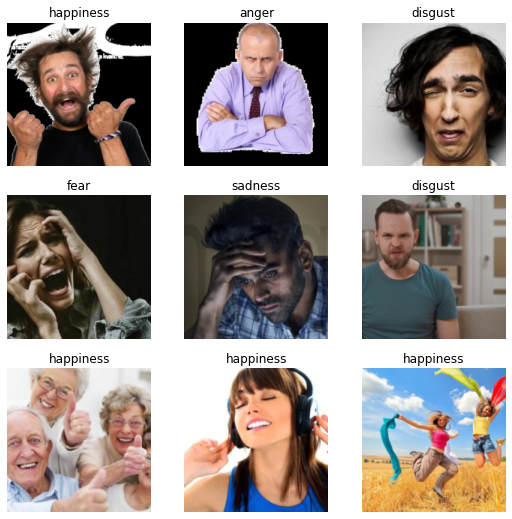

In [22]:
from torchvision.transforms import CenterCrop
# create dataloaders
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(192)
).dataloaders(path, bs=32)

dls.show_batch()

In [23]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(steep=1.5848931980144698e-06, minimum=0.0003019951749593019)

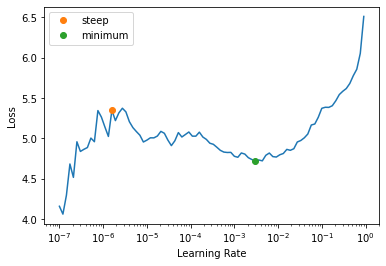

In [27]:
learn.lr_find(suggest_funcs=(SuggestionMethod.Steep, SuggestionMethod.Minimum))

In [26]:
learn.fine_tune(5, base_lr=0.06)

epoch,train_loss,valid_loss,error_rate,time
0,12.651722,50.633644,0.777778,00:01


epoch,train_loss,valid_loss,error_rate,time
0,7.663177,15.503936,0.777778,00:01
1,7.006820,8.777656,0.685185,00:01
2,6.782303,5.074387,0.759259,00:01
3,6.461576,3.259686,0.685185,00:01
4,5.979433,2.608079,0.666667,00:01
